# **Soft voting**


In [139]:
# Enviroment
isColab = False
colab_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"

isKaggle = False
isWsl = True

# Set seed for reproducibility
SEED = 42

## **Loading Enviroment**


In [140]:
import os

# Directory di default
current_dir = os.getcwd()   

if isColab:
    from google.colab import drive # type: ignore
    drive.mount("/gdrive")
    current_dir = colab_dir
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
elif isKaggle:
    kaggle_work_dir = "/kaggle/working/AN2DL-challenge-2"
    os.makedirs(kaggle_work_dir, exist_ok=True)
    current_dir = kaggle_work_dir
    print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    os.chdir(current_dir)
elif isWsl:
    local_pref = r"/mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Esecuzione su WSL. Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)
else:
    print("Esecuzione locale. Salto mount Google Drive.")
    local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

# Define absolute paths
dataset_dir = os.path.join(current_dir, "dataset")
train_set_dir = os.path.join(dataset_dir, "train_data")
test_set_dir = os.path.join(dataset_dir, "test_data")
label_file = os.path.join(dataset_dir, "train_labels.csv")

print(f"Dataset directory: {dataset_dir}")
print(f"Train set directory: {train_set_dir}")
print(f"Test set directory: {test_set_dir}")
print(f"Label file: {label_file}")

Esecuzione su WSL. Directory corrente impostata a: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Changed directory to: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Dataset directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset
Train set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_data
Test set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/test_data
Label file: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_labels.csv


## **Import Libraries**


In [141]:
# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torch.utils.data import TensorDataset, DataLoader
%pip install torchview
from torchview import draw_graph


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
if isColab or isKaggle:
    !pkill -f tensorboard 
    !mkdir -p models
    print("Killed existing TensorBoard instances and created models directory.")

os.makedirs("models", exist_ok=True)
    
%pip install lion-pytorch    

%load_ext tensorboard


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
from lion_pytorch import Lion
from scipy import ndimage

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.1+cu130
Device: cuda


### **Preparing Dataset for colab**

In [142]:
if isColab:
    drive_dataset_dir = os.path.join(current_dir, "dataset")
    local_dataset_dir = "/content/dataset"

    if not os.path.exists(local_dataset_dir):
        print(f"Copying dataset from {drive_dataset_dir} to {local_dataset_dir}...")
        try:
            shutil.copytree(drive_dataset_dir, local_dataset_dir)
            print("Copy complete.")
        except Exception as e:
            print(f"Error copying dataset: {e}")
            print("Falling back to Drive dataset (slow).")
            # If copy fails, we stick to the original dataset_dir (which might need cleaning too if it was used directly)
            dataset_dir = drive_dataset_dir
    else:
        print("Dataset already copied to local runtime.")

    # If copy succeeded (or already existed), use local path
    if os.path.exists(local_dataset_dir):
        dataset_dir = local_dataset_dir

## ⏳ **Data Loading**


In [ ]:
# Loader parameters
APPLY_MASK = False
BATCH_SIZE = 32
LOADER_SHUFFLE = False

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_PADDING = 5

IMG_RESIZE = (224, 224)
INPUT_SHAPE = (3, *IMG_RESIZE)

TEST_SET_SIZE = 0.0
VAL_SET_SIZE = 0.2
TRAIN_SET_SIZE = 1.0 - TEST_SET_SIZE - VAL_SET_SIZE

### **Definitions**


In [144]:
SAMPLES_TO_IGNORE = [
    "img_0001.png",
    "img_0005.png",
    "img_0008.png",
    "img_0012.png",
    "img_0018.png",
    "img_0020.png",
    "img_0022.png",
    "img_0027.png",
    "img_0028.png",
    "img_0036.png",
    "img_0044.png",
    "img_0047.png",
    "img_0048.png",
    "img_0052.png",
    "img_0062.png",
    "img_0078.png",
    "img_0085.png",
    "img_0090.png",
    "img_0094.png",
    "img_0095.png",
    "img_0126.png",
    "img_0129.png",
    "img_0130.png",
    "img_0133.png",
    "img_0136.png",
    "img_0138.png",
    "img_0148.png",
    "img_0150.png",
    "img_0155.png",
    "img_0159.png",
    "img_0161.png",
    "img_0175.png",
    "img_0178.png",
    "img_0179.png",
    "img_0180.png",
    "img_0184.png",
    "img_0187.png",
    "img_0189.png",
    "img_0193.png",
    "img_0196.png",
    "img_0222.png",
    "img_0251.png",
    "img_0254.png",
    "img_0263.png",
    "img_0268.png",
    "img_0286.png",
    "img_0293.png",
    "img_0313.png",
    "img_0319.png",
    "img_0333.png",
    "img_0342.png",
    "img_0344.png",
    "img_0346.png",
    "img_0355.png",
    "img_0368.png",
    "img_0371.png",
    "img_0376.png",
    "img_0380.png",
    "img_0390.png",
    "img_0393.png",
    "img_0407.png",
    "img_0410.png",
    "img_0415.png",
    "img_0424.png",
    "img_0443.png",
    "img_0453.png",
    "img_0459.png",
    "img_0463.png",
    "img_0486.png",
    "img_0497.png",
    "img_0498.png",
    "img_0499.png",
    "img_0509.png",
    "img_0521.png",
    "img_0530.png",
    "img_0531.png",
    "img_0533.png",
    "img_0537.png",
    "img_0540.png",
    "img_0544.png",
    "img_0547.png",
    "img_0557.png",
    "img_0558.png",
    "img_0560.png",
    "img_0565.png",
    "img_0567.png",
    "img_0572.png",
    "img_0578.png",
    "img_0580.png",
    "img_0586.png",
    "img_0602.png",
    "img_0603.png",
    "img_0607.png",
    "img_0609.png",
    "img_0614.png",
    "img_0620.png",
    "img_0623.png",
    "img_0629.png",
    "img_0635.png",
    "img_0639.png",
    "img_0643.png",
    "img_0644.png",
    "img_0645.png",
    "img_0646.png",
    "img_0656.png",
    "img_0657.png",
    "img_0658.png",
    "img_0670.png",
    "img_0673.png",
    "img_0675.png",
]

In [145]:
# Define transformations
from torchvision import transforms


# ADVICE 3
train_transform_tl = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)


train_transform_ft = transforms.Compose(
    [
        transforms.RandomResizedCrop(
            IMG_RESIZE, scale=(0.7, 1.0), ratio=(0.75, 1.33), antialias=True
        ),
        transforms.RandAugment(num_ops=2, magnitude=7),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(15),  # type: ignore
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

data_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

In [146]:
# Load the full dataframe
full_df = pd.read_csv(label_file)

# Remove cursed images
full_df = full_df[~full_df["sample_index"].isin(SAMPLES_TO_IGNORE)].reset_index(
    drop=True
)

# Label mapping
class_names = sorted(full_df["label"].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}
full_df["label_index"] = full_df["label"].map(label_to_index)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [147]:
class MaskedCropDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, padding=5):
        self.samples = []
        self.transform = transform
        self.img_dir = img_dir
        self.padding = padding
        self.is_inference_mode = dataframe is None

        if not self.is_inference_mode:
            for _, row in dataframe.iterrows():
                img_name = row["sample_index"]
                label = row["label_index"]
                self._crop_img(img_dir, img_name, padding=self.padding, label=label)

        else:
            for img_name in sorted(
                f for f in os.listdir(img_dir) if f.startswith("img_")):
                self._crop_img(img_dir, img_name, padding=self.padding, label="")
                    
                      
    def _crop_img(self, img_dir: str, img_name: str, padding=5, label="None"):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(img_dir, img_name.replace("img_", "mask_"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) > 0
        labeled_mask, n_components = ndimage.label(mask)  # type: ignore
        for cid in range(1, n_components + 1):
            ys, xs = np.where(labeled_mask == cid)
            if len(xs) < 15:  # elimina rumore
                continue
            x1, x2 = xs.min(), xs.max()
            y1, y2 = ys.min(), ys.max()
            h, w = image.shape[:2]
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(w, x2 + padding)
            y2 = min(h, y2 + padding)
            patch = image[y1:y2, x1:x2]
            self.samples.append(
                {"patch": patch,
                 "label": label,
                 "parent": img_name
            })
            
            
    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        s = self.samples[idx]
        patch = Image.fromarray(s["patch"])
        if self.transform:
            patch = self.transform(patch)
        return patch, s["label"], s["parent"]
        

In [148]:
def make_loader(ds, batch_size, shuffle, drop_last=False):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(6, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
        persistent_workers=isWsl,
    )

In [149]:
# Train/validation split (stratified)
train_df, val_df = train_test_split(
    full_df,
    test_size=(TEST_SET_SIZE + VAL_SET_SIZE),
    stratify=full_df["label"],
    random_state=SEED,
)
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}")

Train samples: 464, Val samples: 117


In [150]:
train_dataset = MaskedCropDataset(
    train_df,
    train_set_dir,
    transform=train_transform_tl,
    padding=IMG_PADDING,
)
val_dataset = MaskedCropDataset(
    val_df, train_set_dir, transform=data_transforms, padding=IMG_PADDING
)

train_loader = make_loader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_dataset, BATCH_SIZE, shuffle=False, drop_last=False)

# Alias per le fasi di training/fine-tuning
train_tl_loader, val_tl_loader = train_loader, val_loader
train_ft_loader, val_ft_loader = train_loader, val_loader

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Input tensor shape: {INPUT_SHAPE}")

Train samples: 4076, Val samples: 946
Input tensor shape: (3, 224, 224)


In [151]:
def unnormalize(img, mean, std):
    img = np.array(img, copy=True)
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img, 0, 1)


def show_mask_patch_effect(dataset, train_transform, data_transforms, n=3):
    parents = list({s["parent"] for s in dataset.samples})
    parents = random.sample(parents, min(n, len(parents)))

    for img_name in parents:
        img_path = os.path.join(dataset.img_dir, img_name)
        mask_path = os.path.join(dataset.img_dir, img_name.replace("img_", "mask_"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) > 0

        labeled_mask, n_components = ndimage.label(mask)  # type: ignore

        fig = plt.figure(figsize=(4 * (n_components + 1), 5))
        gs = fig.add_gridspec(1, n_components + 1)

        # Originale + maschera
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(image)
        ax0.imshow(mask, alpha=0.4, cmap="Reds")
        ax0.set_title("Originale + Maschera")
        ax0.axis("off")

        col = 1
        for cid in range(1, n_components + 1):
            ys, xs = np.where(labeled_mask == cid)
            if len(xs) < 15:
                continue

            x1, x2 = xs.min(), xs.max()
            y1, y2 = ys.min(), ys.max()

            patch = image[y1:y2, x1:x2]
            patch_pil = Image.fromarray(patch)

            train_img = train_transform(patch_pil)
            train_img = unnormalize(train_img.numpy(), IMAGENET_MEAN, IMAGENET_STD)

            ax = fig.add_subplot(gs[col])
            ax.imshow(np.transpose(train_img, (1, 2, 0)))
            ax.set_title(f"Patch {cid}")
            ax.axis("off")
            col += 1

        plt.suptitle(f"{img_name} – Patch estratte dai blob", fontsize=14)
        plt.show()

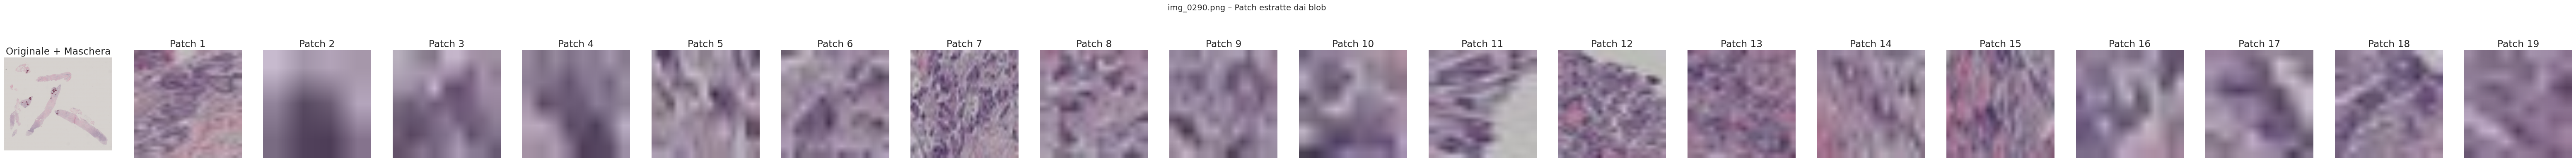

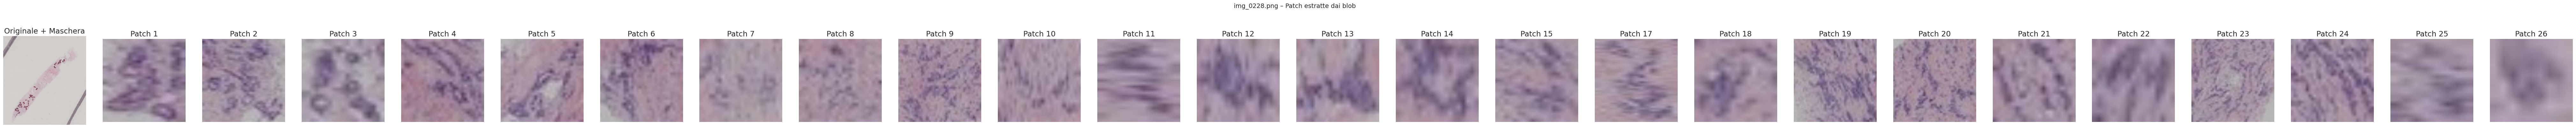

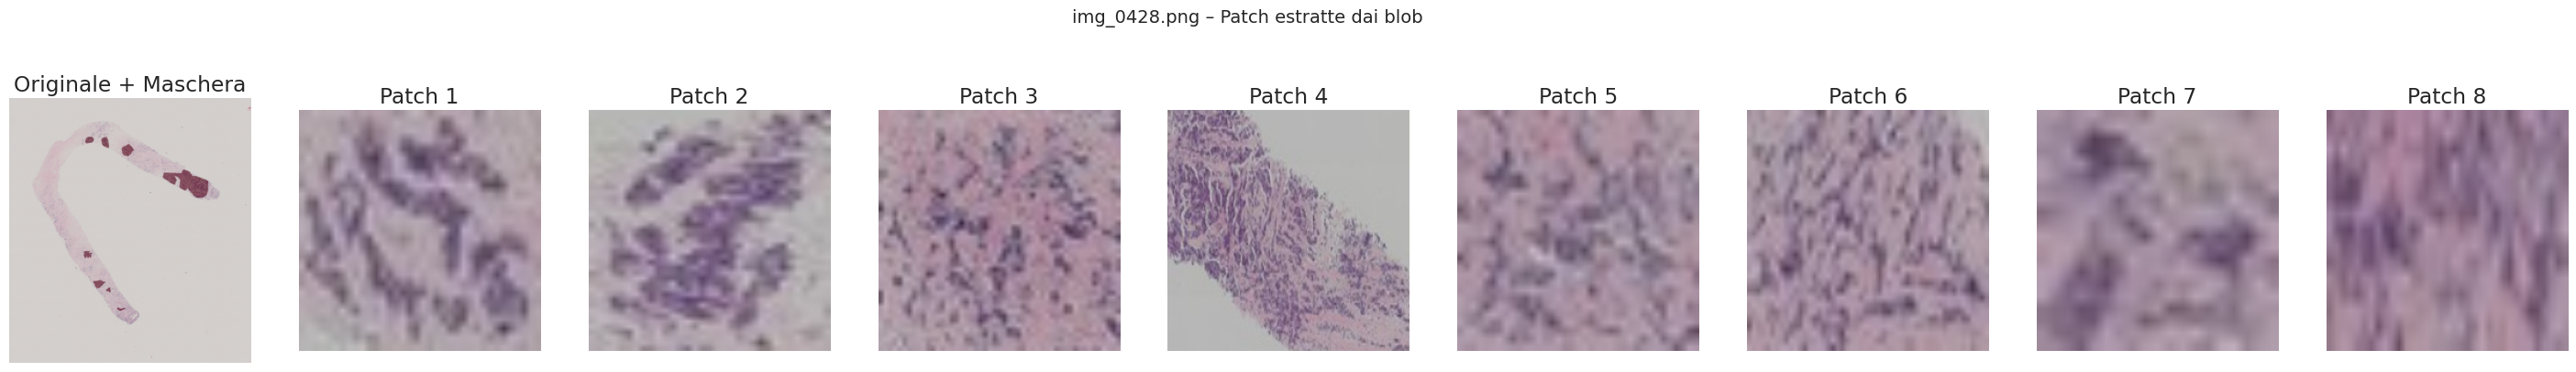

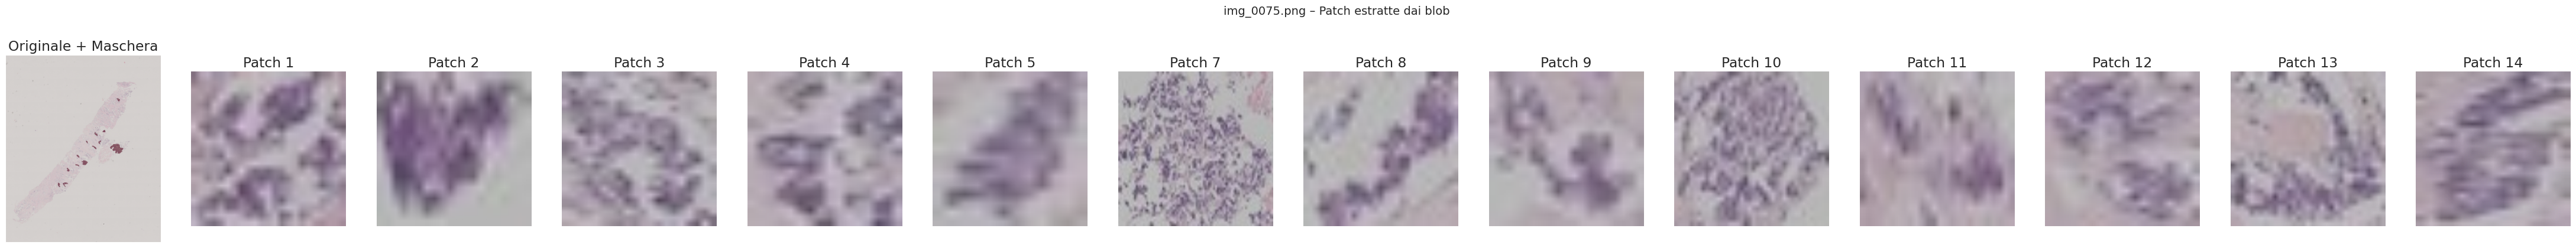

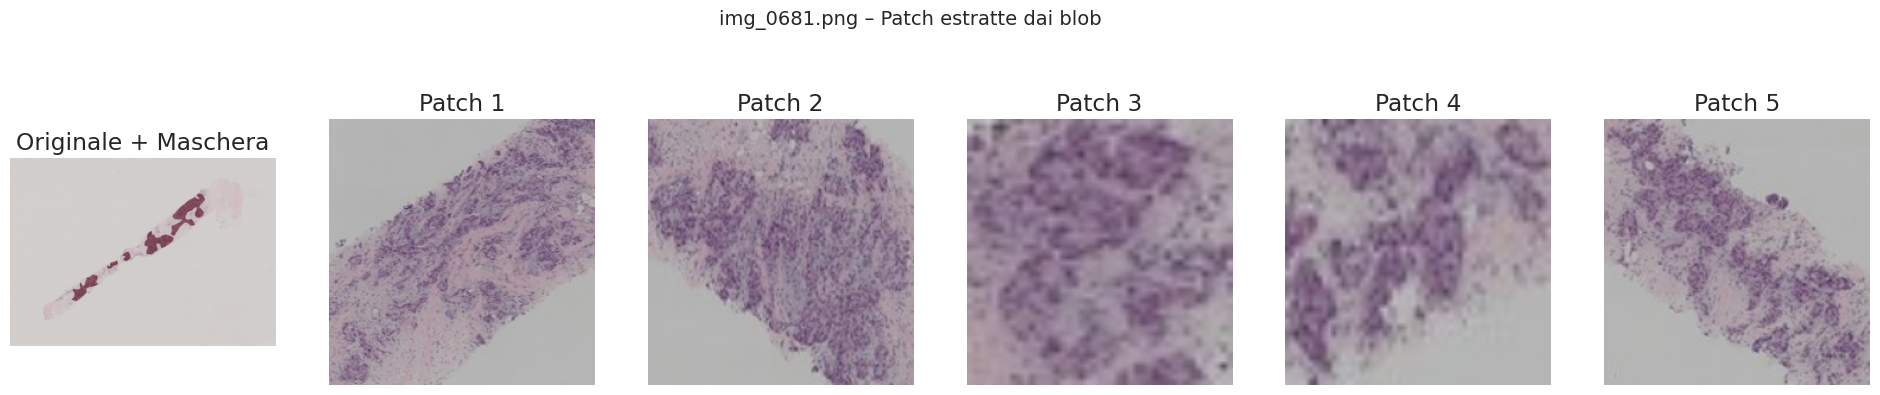

In [152]:
# TODO: fix the show mask function, beacuse data_transform does nothing

show_mask_patch_effect(
    dataset=train_dataset,
    train_transform=train_transform_tl,
    data_transforms=data_transforms,
    n=5,
)

## 🧮 **Network Parameters**


In [153]:

# Training parameters
LEARNING_RATE = 1e-5
EPOCHS = 200
PATIENCE = 20
DROPOUT_RATE = 0.25
WEIGHT_DECAY = 1e-2

# Regularization
DROPOUT_RATE = 0.3
LABEL_SMOOTHING = 0.05

# Fine tuning parameters
FT_LEARNING_RATE = 5e-6
FT_WEIGHT_DECAY = 1e-3
FT_DROPOUT_RATE = 0.2
N_LAYERS_TO_UNFREEZE = 20

VERBOSE = 5

In [154]:
from sklearn.utils.class_weight import compute_class_weight

# calcolo class weights dal TRAIN
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=train_df["label_index"].values,
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=LABEL_SMOOTHING,
)

print("Class weights:", class_weights)

Class weights: [0.96666667 0.92063492 0.71165644 2.10909091]


## 🧠 **Training Functions**


In [155]:
from sklearn.metrics import accuracy_score, f1_score


def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets, _ in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")): # type: ignore
            logits = model(inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        preds = logits.argmax(dim=1)
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1 = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

In [156]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets, _ in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")): # type: ignore
                logits = model(inputs)
                loss = criterion(logits, targets)
            running_loss += loss.item() * inputs.size(0)
            preds = logits.argmax(dim=1)
            all_predictions.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1 = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

In [157]:
def fit(
    model,
    train_loader,
    val_loader,
    epochs,
    criterion,
    optimizer,
    scaler,
    device,
    scheduler=None,
    patience=0,
    evaluation_metric="val_f1",
    mode="max",
    restore_best_weights=True,
    writer=None,
    verbose=1,
    experiment_name="",
):

    history = {"train_loss": [], "train_f1": [], "val_loss": [], "val_f1": []}

    best_metric = float("-inf") if mode == "max" else float("inf")
    best_epoch = 0
    patience_counter = 0

    print(f"Training {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        train_loss, _, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )
        val_loss, _, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

        if scheduler is not None:
            scheduler.step(val_f1)

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_f1)

        if writer is not None:
            writer.add_scalar("Loss/Training", train_loss, epoch)
            writer.add_scalar("F1/Training", train_f1, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("F1/Validation", val_f1, epoch)

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(
                f"Epoch {epoch:3d}/{epochs} | "
                f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f} | "
                f"LR: {scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[0]['lr']:.6f}"
            )

        current_metric = history[evaluation_metric][-1]
        is_improvement = (
            (current_metric > best_metric)
            if mode == "max"
            else (current_metric < best_metric)
        )

        if is_improvement:
            best_metric = current_metric
            best_epoch = epoch
            torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and patience > 0:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
        print(
            f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}"
        )
    elif patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    if writer is not None:
        writer.close()

    return model, history

## 🛠️ **Transfer Learning**


In [158]:
class MobileNetV3TransferLearning(nn.Module):
    """MobileNetV3Small pretrained on ImageNet."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()
        self.freeze_backbone = freeze_backbone
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

        self.backbone = torchvision.models.mobilenet_v3_large(
            weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
        )
        if self.freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, in_features),  # type: ignore
            nn.Hardswish(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(in_features, self.num_classes),  # type: ignore
        )

    def forward(self, x):
        return self.backbone(x)

In [159]:
tl_model = MobileNetV3TransferLearning(
    num_classes, DROPOUT_RATE, freeze_backbone=True
).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/berto/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:23<00:00, 955kB/s] 


In [160]:
# Setup training
experiment_name = "transfer_learning"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

optimizer = Lion(tl_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5,
    threshold=1e-3,
    min_lr=1e-6,
)

scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))  # type: ignore

In [161]:
%%time
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_tl_loader,
    val_loader=val_tl_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    scheduler=scheduler,
    writer=writer,
    verbose=VERBOSE,
    experiment_name=experiment_name,
    patience= PATIENCE
)

final_f1_score = max(tl_history['val_f1'])
print(f'Maximum f1 score: {final_f1_score}')

Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3886, F1=0.2694 | Val: Loss=1.3897, F1=0.2756 | LR: 0.000010
Epoch   5/200 | Train: Loss=1.3013, F1=0.3838 | Val: Loss=1.3822, F1=0.2905 | LR: 0.000010
Epoch  10/200 | Train: Loss=1.2670, F1=0.4069 | Val: Loss=1.4088, F1=0.2652 | LR: 0.000005
Epoch  15/200 | Train: Loss=1.2550, F1=0.4222 | Val: Loss=1.4101, F1=0.2665 | LR: 0.000003
Epoch  20/200 | Train: Loss=1.2475, F1=0.4262 | Val: Loss=1.4060, F1=0.2808 | LR: 0.000003
Early stopping triggered after 23 epochs.
Best model restored from epoch 3 with val_f1 0.2976
Maximum f1 score: 0.29764735814370125
CPU times: user 6min 2s, sys: 1min 34s, total: 7min 36s
Wall time: 6min 47s


## **Fine-Tuning**


In [162]:
train_dataset.transform = train_transform_ft

train_ft_loader = make_loader(train_dataset, BATCH_SIZE, shuffle=True)
val_ft_loader = make_loader(val_dataset, BATCH_SIZE, shuffle=False)

ft_model = MobileNetV3TransferLearning(
    num_classes, FT_DROPOUT_RATE, freeze_backbone=False
).to(device)
ft_model.load_state_dict(torch.load(f"models/{experiment_name}_model.pt"))

for param in ft_model.backbone.parameters():
    param.requires_grad = False
backbone_layers = list(ft_model.backbone.features.children())
for layer in backbone_layers[-N_LAYERS_TO_UNFREEZE:]:
    for param in layer.parameters():
        param.requires_grad = True

total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Total parameters: 3,898,356
Trainable parameters: 2,971,952
Frozen parameters: 926,404


In [163]:
experiment_name = "fine_tuning"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

optimizer = Lion(
    ft_model.parameters(), lr=FT_LEARNING_RATE, weight_decay=FT_WEIGHT_DECAY
)
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))  # type: ignore

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5,
    threshold=1e-3,
    min_lr=1e-6,
)

In [164]:
%%time

ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    scheduler=scheduler,
    writer=writer,
    verbose=VERBOSE,
    experiment_name=experiment_name,
    patience=PATIENCE,
)

final_f1_score = max(ft_history['val_f1'])
print(f'Maximum f1 score: {final_f1_score}')

Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3539, F1=0.3275 | Val: Loss=1.3654, F1=0.2936 | LR: 0.000005
Epoch   5/200 | Train: Loss=1.2831, F1=0.3759 | Val: Loss=1.3677, F1=0.2793 | LR: 0.000005
Epoch  10/200 | Train: Loss=1.2288, F1=0.4155 | Val: Loss=1.3757, F1=0.2805 | LR: 0.000005
Epoch  15/200 | Train: Loss=1.1829, F1=0.4477 | Val: Loss=1.3886, F1=0.2952 | LR: 0.000005
Epoch  20/200 | Train: Loss=1.1457, F1=0.4703 | Val: Loss=1.4035, F1=0.3133 | LR: 0.000005
Epoch  25/200 | Train: Loss=1.1022, F1=0.4937 | Val: Loss=1.4450, F1=0.3197 | LR: 0.000005
Epoch  30/200 | Train: Loss=1.0496, F1=0.5425 | Val: Loss=1.4419, F1=0.3334 | LR: 0.000005
Epoch  35/200 | Train: Loss=0.9940, F1=0.5809 | Val: Loss=1.4378, F1=0.3420 | LR: 0.000003
Epoch  40/200 | Train: Loss=0.9796, F1=0.5835 | Val: Loss=1.4590, F1=0.3476 | LR: 0.000003
Epoch  45/200 | Train: Loss=0.9576, F1=0.6103 | Val: Loss=1.4961, F1=0.3415 | LR: 0.000003
Epoch  50/200 | Train: Loss=0.9023, F1=0.6318 | Val: Loss=1.5023, F

## **Evaluation**


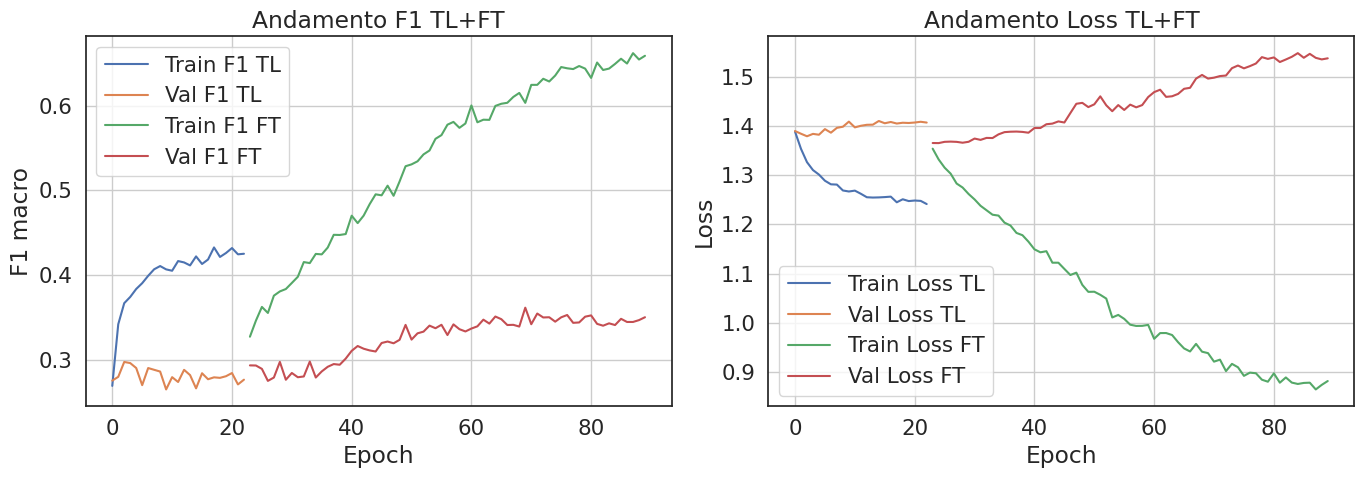

In [165]:
# Plot TL vs FT
def plot_history(tl_history, ft_history):
    epochs_tl = len(tl_history["val_f1"])
    epochs_ft = len(ft_history["val_f1"])

    plt.figure(figsize=(14, 5))

    # F1
    plt.subplot(1, 2, 1)
    plt.plot(tl_history["train_f1"], label="Train F1 TL")
    plt.plot(tl_history["val_f1"], label="Val F1 TL")
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["train_f1"],
        label="Train F1 FT",
    )
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft), ft_history["val_f1"], label="Val F1 FT"
    )
    plt.xlabel("Epoch")
    plt.ylabel("F1 macro")
    plt.title("Andamento F1 TL+FT")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(tl_history["train_loss"], label="Train Loss TL")
    plt.plot(tl_history["val_loss"], label="Val Loss TL")
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["train_loss"],
        label="Train Loss FT",
    )
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["val_loss"],
        label="Val Loss FT",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Andamento Loss TL+FT")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_history(tl_history, ft_history)

In [166]:
from sklearn.metrics import f1_score


def evaluate_macro_f1(model, loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    return f1_score(y_true, y_pred, average="macro")

In [167]:
best_model = MobileNetV3TransferLearning(
    num_classes, DROPOUT_RATE, freeze_backbone=False
).to(device)
best_model.load_state_dict(torch.load(f"models/{experiment_name}_model.pt"))
best_model.eval()

MobileNetV3TransferLearning(
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Co

In [168]:
train_f1 = evaluate_macro_f1(best_model, train_ft_loader, device)
val_f1 = evaluate_macro_f1(best_model, val_ft_loader, device)

print(f"F1 TRAIN (macro): {train_f1:.4f}")
print(f"F1 VAL   (macro): {val_f1:.4f}")

F1 TRAIN (macro): 0.6616
F1 VAL   (macro): 0.3600


## **Inference on test_data**


In [169]:
from collections import defaultdict
import torch.nn.functional as F

test_dataset = MaskedCropDataset(
    dataframe=None, img_dir=test_set_dir, transform=data_transforms, padding=IMG_PADDING
)

test_loader = make_loader(test_dataset, BATCH_SIZE, shuffle=False, drop_last=False)

votes = defaultdict(list)

with torch.no_grad():
    for patches, _, img_names in test_loader:
        outputs = F.softmax(best_model(patches.to(device)), dim=1)
        for img, p in zip(img_names, outputs.cpu()):
            votes[img].append(p)

final_preds = {}
for img, plist in votes.items():
    mean_prob = torch.stack(plist).mean(dim=0)
    final_preds[img] = mean_prob.argmax().item()

In [170]:
# Ordine stabile per submission
image_names = sorted(final_preds.keys())

submission_df = pd.DataFrame(
    {
        "sample_index": image_names,
        "label": [class_names[final_preds[f]] for f in image_names],
    }
)

os.makedirs(os.path.join(current_dir, "submission"), exist_ok=True)
submission_df.to_csv(
    os.path.join(current_dir, "submission", "MobileNet_soft_voting_v4.csv"), index=False
)

print(len(submission_df), "righe ? OK")
submission_df.head()

477 righe ? OK


sample_index            label
0  img_0000.png        Luminal A
1  img_0001.png        Luminal B
2  img_0002.png          HER2(+)
3  img_0003.png  Triple negative
4  img_0004.png        Luminal B